In [166]:
import torch
import torch.nn as nn

# Simulator and Prior

In [167]:
def simulator(theta, num_samples):
    # Extract parameters
    mu = theta[:, 0:1]  # mean in 1D
    

    # Generate random 2D inputs
    x = torch.randn(mu.shape[0], num_samples)
    x = x + mu  # shift by mean

    return x

In [168]:
def sample_prior(n_samples=1000):
    mu = torch.randn(n_samples, 1) * 10
    return mu

# PREDEP Training

In [169]:
from metrics_network.predep import PredepNetwork

In [170]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [171]:
input_dim = 1000
context_dim = 1
output_dim = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [172]:
encoder = MLP(input_dim=input_dim, hidden_dim=input_dim, output_dim=context_dim)
decoder = MLP(input_dim=context_dim, hidden_dim=input_dim, output_dim=output_dim)

In [173]:
PREDEP_model = PredepNetwork(encoder_model=encoder, decoder_model=decoder,num_samples=10000).to(device)  

In [174]:
optimizer = torch.optim.Adam(PREDEP_model.parameters(), lr=1e-5)

In [175]:
num_epochs = 1000
batch_size = 1024

In [ ]:
for epoch in range(num_epochs):
  # Train density estimator  

  theta = sample_prior(batch_size)
  x = simulator(theta,num_samples=input_dim)

  theta = theta.to(device)
  x = x.to(device).view(batch_size,-1)

  summary, predep = PREDEP_model(x = x, y = theta)

  loss = -predep

  optimizer.zero_grad()
  loss.mean().backward()
  optimizer.step()

  if epoch % 100 == 0:
      print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: -0.0285
Epoch 100, Loss: -0.0830
Epoch 200, Loss: -0.1327
Epoch 300, Loss: -0.0625
Epoch 400, Loss: -0.0868
Epoch 500, Loss: -0.0564
Epoch 600, Loss: -0.0647
Epoch 700, Loss: -0.1305
Epoch 800, Loss: -0.1912
Epoch 900, Loss: -0.0675


# Amortized

In [177]:
from amortized.amortized import train_amortized_flow
from amortized.flow import AmortizedFlowModel

In [178]:
amortized_model = AmortizedFlowModel(data_dim=output_dim, 
                                     context_dim=context_dim,
                                     summarize=PREDEP_model,
                                     device = device)

In [179]:
optimizer_amortized = torch.optim.Adam(amortized_model.flow.parameters(), lr=1e-4)

In [180]:
for epoch in range(1000):
    amortized_model.flow.train()

    theta = sample_prior(batch_size)
    x = simulator(theta,num_samples=input_dim)

    theta = theta.to(device)
    x = x.to(device).view(batch_size,-1)

    context = PREDEP_model.summarize(x)

    loss = -amortized_model.log_prob(theta, context)

    optimizer_amortized.zero_grad()
    loss.mean().backward()
    optimizer_amortized.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Amortized Loss: {loss.mean().item():.4f}")


Epoch 0, Amortized Loss: 477.2904
Epoch 100, Amortized Loss: 3.0100
Epoch 200, Amortized Loss: 5.7852
Epoch 300, Amortized Loss: 5.3256
Epoch 400, Amortized Loss: 1.8249
Epoch 500, Amortized Loss: -0.1964
Epoch 600, Amortized Loss: -0.3849
Epoch 700, Amortized Loss: 0.1899
Epoch 800, Amortized Loss: 2.1429
Epoch 900, Amortized Loss: 0.8041


# Posterior Comparison

In [190]:
theta = torch.tensor([[-15.5]])
x = simulator(theta,num_samples=input_dim)
x_obs_tilde = PREDEP_model.summarize(x.view(1,-1).to(device))

In [191]:
# Learned posterior samples
posterior_samples = amortized_model.flow.sample(10000, context=x_obs_tilde).cpu().detach().numpy()

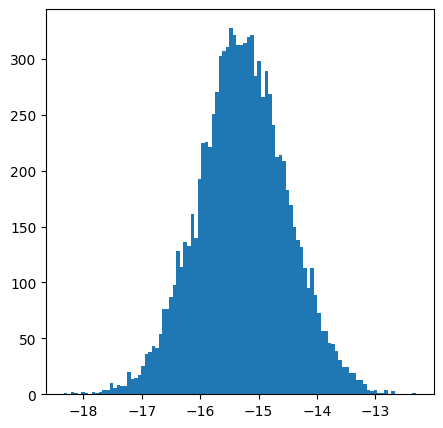

In [192]:
import matplotlib.pyplot as plt
import numpy as np

fig,axs = plt.subplots(1,theta.size(-1),figsize = (5 * theta.size(-1),5),)

for i in range(theta.size(-1)):
  axs.hist(posterior_samples[:,:,i].flatten(),bins=100)